# ENERGY BASE MODELS (EBM)

## Imports

In [38]:
from tensorflow.keras import (
    datasets,
    layers,
    activations,
    models,
    
)

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random

## Functions

In [26]:
def preprocess_img(imgs):
    imgs= (imgs.astype('float32') - 127.5) / 127.5

    # (0,0) - means do not change number of images in the batch
    # (2,2),(2,2) - means create a frame thick=2
    # constant_values - means fill fram with -1.0
    imgs = np.pad(imgs, ((0,0), (2,2), (2,2)), constant_values=-1.0 )
    imgs = np.expand_dims(imgs, -1)

    return imgs

def sample_batch(dataset):
    batch= dataset.take(1).get_single_element()

    if isinstance(batch, tuple):
        batch= batch[0]

    return batch.numpy()


def display_mnist_img_tf(img_tf):

    if img_tf.max() > 1.0:
        img_tf= img_tf / 255.0
    elif img_tf.min() < 0.0:
        img_tf= (img_tf + 1.0) / 2.0
        
    plt.figure(figsize=(3,3))
    plt.imshow(img_tf[0].astype('float32'))
    plt.axis('off')
    plt.show()
    

## LOAD AND PRE-PROCESS DATA

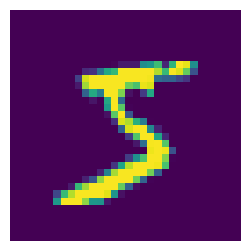

CPU times: user 686 ms, sys: 198 ms, total: 884 ms
Wall time: 916 ms


In [28]:
%%time
batch_size= 128

(x_train, _), (x_test, _) = datasets.mnist.load_data()

x_train= preprocess_img(x_train)
x_test= preprocess_img(x_test)

x_train= tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size)
x_test= tf.data.Dataset.from_tensor_slices(x_test).batch(batch_size)

display_mnist_img_tf(sample_batch(x_train))

## EBM

### NN Architecture

In [35]:
img_size= 32
ch_n= 1

ebm_input= layers.Input(
    shape=(img_size, img_size, ch_n)
)

x= layers.Conv2D(
    16,
    kernel_size=5,
    strides=2,
    padding='same',
    activation= activations.swish
)(ebm_input)

x= layers.Conv2D(
    32,
    kernel_size=3,
    strides=2,
    padding='same',
    activation=activations.swish
)(x)
x= layers.Conv2D(
    64,
    kernel_size=3,
    strides=2,
    padding='same',
    activation=activations.swish
)(x)
x= layers.Conv2D(
    64,
    kernel_size=3,
    strides=2,
    padding='same',
    activation=activations.swish
)(x)

x= layers.Flatten()(x)
x= layers.Dense(
    64,
    activation= activations.swish
)(x)

ebm_output= layers.Dense(1)(x)

model= models.Model(ebm_input, ebm_output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 16)     │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 4, 4, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 2, 2, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,993 (300.75 KB)

 Trainable params: 76,993 (300.75 KB)

 Non-trainable params: 0 (0.00 B)

### Langevin

In [36]:
def generate_samples(model, in_imgs, steps, step_size, noise, return_img_per_step=False):
    imgs_per_step= []

    for _ in range(steps):
        in_imgs += tf.random.normal(in_imgs.shape, mean=0, stddev=noise)
        in_imgs = tf.clip_by_value(in_imgs, -1.0, 1.0)

        with tf.GradientTape() as tape:
            tape.watch(in_imgs)
            out_score= model(in_imgs)

        grads= tape.gradient(out_score, in_imgs)
        grads= tf.clip_by_value(in_imgs, -1.0, 1.0)

        if return_img_per_step:
            imgs_per_step.append(in_imgs)
            
    if return_img_per_step:
        return tf.stack(imgs_per_step, axis=0)
    else:
        return in_imgs

### Buffer

In [ ]:
buffer_size= 8192

class Buffer:
    def __init__(self, model):
        super().__init__()
        self.model=model
        self.examples= [
            tf.random.uniform(shape=(img_size, img_size, ch_n)) * 2 -1 for _ in range(batch_size)
        ]

    def sample_new_examples(self, steps, step_size, noise):
        n_new= np.random.binomial(batch_size, noise)
        random_imgs= (
            tf.random.uniform(
                (
                    n_new, 
                    img_size, 
                    img_size, 
                    ch_n
                )
            ) * 2 -1)
        
        old_imgs= tf.concat(
            random.choices(
                self.examples, 
                k=batch_size - n_new
            ), axis=0)
        
        inp_imgs= tf.concat(
            [
                rand_imgs, 
                old_imgs
            ], axis=0)
        
        inp_imgs= generate_samples(
            self.model, 
            inp_imgs,
            steps=step,
            step_size=step_size,
            noise=noise
        )

        self.examples= tf.split(
            inp_imgs,
            batch_size,
            axis=0
        ) + self.examples

        self.examples= self_examples[:buffer_size]

        return inp_imgs
        

### Model